In [1]:
import random
from quantumnet.components import Network, Host
from quantumnet.components import ServerNode, ClientNode, RegularNode
from quantumnet.objects import Qubit, Logger
import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit

In [ ]:
class ClassificadorQML(torch.nn.Module):
    """
    Classe para criar um modelo de aprendizado de máquina quântico (QML)
    baseado no template StronglyEntanglingLayers.
    """
    def __init__(self, dim_entrada, dim_saida, num_qubits, num_camadas):
        super().__init__()
        torch.manual_seed(1337)  # Fixar seed para reprodutibilidade
        self.num_qubits = num_qubits
        self.dim_saida = dim_saida
        self.num_camadas = num_camadas
        self.dispositivo = qml.device("lightning.qubit", wires=self.num_qubits)

        # Formato dos pesos do circuito
        self.formato_pesos = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_camadas, n_wires=self.num_qubits
        )

        # Criar o QNode
        self.qnode = qml.QNode(self.circuito, self.dispositivo)

    def circuito(self, inputs, pesos, viés):
        """Define o circuito quântico do modelo."""
        inputs = torch.tensor(inputs, dtype=torch.float32)  
        inputs = torch.reshape(inputs, self.formato_pesos)

        qml.StronglyEntanglingLayers(
            weights=pesos * inputs + viés, wires=range(self.num_qubits)
        )
        return [qml.expval(qml.PauliZ(i)) for i in range(self.dim_saida)]

    def gerar_qiskit_circuit(self):
        """
        Transforma o circuito PennyLane em um circuito Qiskit compatível com a rede.
        """
        qc = QuantumCircuit(self.num_qubits)

        # Criando pesos e viés fictícios
        pesos_falsos = np.random.rand(*self.formato_pesos)
        vies_falso = np.random.rand(*self.formato_pesos)
        entradas_falsas = np.random.rand(*self.formato_pesos)  

        # Extraindo operações
        with qml.tape.QuantumTape() as tape:
            self.qnode(entradas_falsas, pesos_falsos, vies_falso)

        for op in tape.operations:
            nome_puerta = op.name
            qubits = op.wires.tolist()

            if nome_puerta == "RX":
                qc.rx(random.uniform(0, 2 * np.pi), qubits[0])
            elif nome_puerta == "RY":
                qc.ry(random.uniform(0, 2 * np.pi), qubits[0])
            elif nome_puerta == "RZ":
                qc.rz(random.uniform(0, 2 * np.pi), qubits[0])
            elif nome_puerta == "CNOT":
                qc.cx(qubits[0], qubits[1])
            elif nome_puerta == "CZ":
                qc.cz(qubits[0], qubits[1])
            elif nome_puerta == "SWAP":
                qc.swap(qubits[0], qubits[1])

        return qc

Hosts inicializados
Canais inicializados
Pares EPRs adicionados


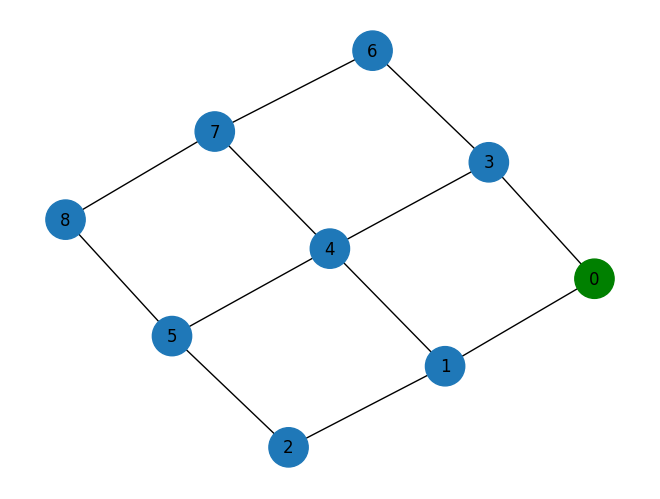

In [2]:
# Definições da rede
rede = Network()
rede.set_ready_topology('grade', 8, 3, 3)  
rede.draw()
Logger.activate(Logger)    

In [3]:
# Definições do modelo quântico
dim_entrada = 256  # Dimensão da entrada
num_classes = 4  # Número de classes de saída
num_camadas = 32  # Número de camadas do circuito
num_qubits = 8  # Número de qubits no circuito
num_repeticoes = 3  # Número de repetições da entrada

# Definição do dispositivo (CPU ou GPU)
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando o dispositivo:", dispositivo)

class ClassificadorQML(torch.nn.Module):
    """
    Classe que cria um modelo de aprendizado de máquina quântico (QML)
    baseado no template StronglyEntanglingLayers.

    Parâmetros:
        dim_entrada: dimensão dos exemplos de entrada
        dim_saida: dimensão da saída (número de classes)
        num_qubits: número de qubits no circuito
        num_camadas: número de camadas no template StronglyEntanglingLayers
    """
    def __init__(self, dim_entrada, dim_saida, num_qubits, num_camadas):
        super().__init__()
        torch.manual_seed(1337)  # Semente fixa para reprodutibilidade
        self.num_qubits = num_qubits
        self.dim_saida = dim_saida
        self.num_camadas = num_camadas
        self.dispositivo = qml.device("lightning.qubit", wires=self.num_qubits)

        # Define a forma dos pesos do circuito
        self.formato_pesos = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_camadas, n_wires=self.num_qubits
        )

        # Criando o QNode
        self.qnode = qml.QNode(self.circuito, self.dispositivo)

    def circuito(self, inputs, pesos, viés):
        """
        Define o circuito quântico usado no modelo.
        """
        # **Correção: Gerar inputs com tamanho correto**
        if len(inputs) != np.prod(self.formato_pesos):
            inputs = np.random.rand(*self.formato_pesos)  # Gerar entradas aleatórias

        inputs = torch.tensor(inputs, dtype=torch.float32)  
        inputs = torch.reshape(inputs, self.formato_pesos)

        qml.StronglyEntanglingLayers(
            weights=pesos * inputs + viés, wires=range(self.num_qubits)
        )
        return [qml.expval(qml.PauliZ(i)) for i in range(self.dim_saida)]

# Criando uma instância do modelo quântico
modelo_qml = ClassificadorQML(dim_entrada, num_classes, num_qubits, num_camadas)
modelo_qml.to(dispositivo)

# **Criando um circuito de porta diretamente na rede**
def adicionar_circuito_na_rede(rede, qnode, num_qubits):
    """
    Transforma um circuito PennyLane QNode em um formato compatível com a rede quantumnet.
    """
    # Criando um dicionário para representar o circuito
    circuito_rede = {
        "num_qubits": num_qubits,
        "gates": []
    }

    # Criando pesos e viés fictícios para executar o QNode
    pesos_falsos = np.random.rand(*qnode.device.wires.tolist())
    vies_falso = np.random.rand(*qnode.device.wires.tolist())
    entradas_falsas = np.random.rand(*modelo_qml.formato_pesos)  # **Correção: Geração correta de inputs**

    # Extraindo operações do QNode
    with qml.tape.QuantumTape() as tape:
        qnode(entradas_falsas, pesos_falsos, vies_falso)  # Chamando o circuito com todos os argumentos necessários

    for op in tape.operations:
        nome_puerta = op.name
        qubits = op.wires.tolist()
        parametros = [p.numpy() if hasattr(p, 'numpy') else p for p in op.parameters]

        # Adicionando a porta ao circuito
        circuito_rede["gates"].append({
            "name": nome_puerta,
            "wires": qubits,
            "params": parametros
        })

    return circuito_rede

# Convertendo o circuito do PennyLane para um formato compatível com a rede
circuito_quantico = adicionar_circuito_na_rede(rede, modelo_qml.qnode, num_qubits)

# **Executando o protocolo AC_BQC com o circuito convertido**
rede.application_layer.run_app(
    "AC_BQC",
    alice_id=6,
    bob_id=0,
    num_qubits=10,
    scenario=1,
    circuit_depth=num_camadas,  # Número de camadas como profundidade do circuito
    circuit_data=circuito_quantico  # Passando o circuito convertido
)

Usando o dispositivo: cpu


TypeError: unsupported operand type(s) for *: 'tensor' and 'Tensor'